# Анализ факторов влияющих на привлекательность стартапа и прогнозирование его успешности на краудфандинговой платформе Kickstarter.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import researchpy as rp
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [2]:
ks = pd.read_csv('ks-projects-201801.csv')

In [3]:
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
ks.state.unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

Оставим только те проекты по которым есть результат (положительный или отрицательный)

In [6]:
ks = ks[(ks.state == 'failed') | (ks.state == 'successful')]

Добавьм колонку содержащую количество дней сбора, а так же колонки с годом и месяцем начала сбора средств.

In [7]:
ks['launched'] = pd.to_datetime(ks.launched).dt.normalize()

In [8]:
ks['amount_days']= pd.to_datetime(ks.deadline) - ks.launched

In [9]:
ks['amount_days'] = (ks.amount_days / np.timedelta64(1, 'D')).astype(int) 

In [10]:
ks['year_start'] = ks['launched'].dt.year

In [11]:
ks['month_start'] = ks['launched'].dt.month

Добавим колонку, в которой будет результат переведенный из строкового в числовой.

In [12]:
def result_ (value):
    if value == 'failed':
        return 0
    else:
        return 1

In [13]:
ks['result'] = ks.state.apply(result_)

Добавим колонку содержащую разницу между полученными средствами и запрашиваемыми

In [14]:
ks['diff_money'] = ks['usd_pledged_real'] - ks['usd_goal_real']

Удалим колонку usd pledged так как есть более точная альтернатива - usd_pledged_real, к тому же без пропущеных значений

А так же колонки goal, pledged так как есть альтернатива со значениями конвертированными в доллары(usd_pledged_real, usd_goal_real), соответственно колонка currency тоже больше не нужна. 

В столбцах deadline и launched так же более нет необходимости.

ID как таковой тоже не нужен в данной работе. Предварительно изменим отсутствующие имена проектов на соответствующие ID для того чтобы не было NaN значений.

In [15]:
ks.name.fillna(ks.ID, inplace=True)

In [16]:
print(ks.columns)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'amount_days',
       'year_start', 'month_start', 'result', 'diff_money'],
      dtype='object')


In [17]:
ks = ks[['name', 'category', 'main_category', 'country',
         'year_start', 'month_start', 'amount_days', 'backers', 
         'usd_pledged_real', 'usd_goal_real', 'diff_money', 'state', 'result']]

In [18]:
ks.head()

,name,category,main_category,country,year_start,month_start,amount_days,backers,usd_pledged_real,usd_goal_real,diff_money,state,result
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GB,2015,8,59,0,0.0,1533.95,-1533.95,failed,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,US,2017,9,60,15,2421.0,30000.00,-27579.00,failed,0
2,Where is Hank?,Narrative Film,Film & Video,US,2013,1,45,3,220.0,45000.00,-44780.00,failed,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,2012,3,30,1,1.0,5000.00,-4999.00,failed,0
5,Monarch Espresso Bar,Restaurants,Food,US,2016,2,35,224,52375.0,50000.00,2375.00,successful,1


## Анализ данных

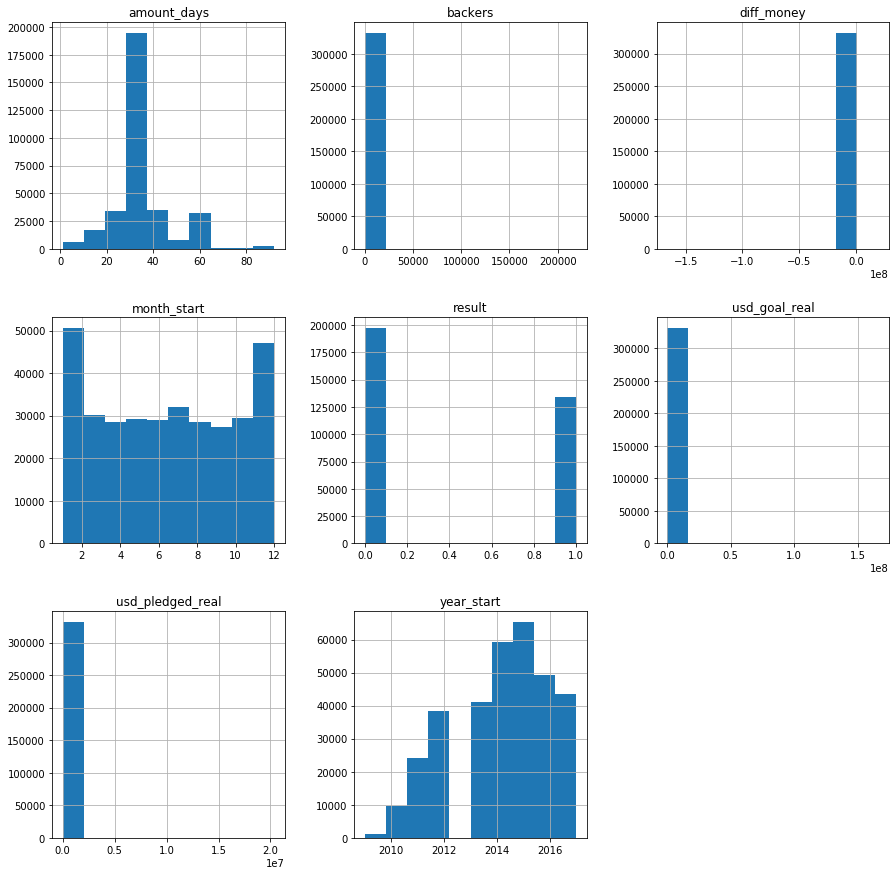

In [19]:
ks.hist()
fig=plt.gcf()
fig.set_size_inches(15,15)
plt.show()

In [20]:
round(ks.describe())

,year_start,month_start,amount_days,backers,usd_pledged_real,usd_goal_real,diff_money,result
count,331675.0,331675.0,331675.0,331675.0,331675.0,331675.0,331675.0,331675.0
mean,2014.0,6.0,34.0,116.0,9943.0,41510.0,-31567.0,0.0
std,2.0,3.0,13.0,965.0,96733.0,1108930.0,1112528.0,0.0
min,2009.0,1.0,1.0,0.0,0.0,0.0,-166361391.0,0.0
25%,2013.0,4.0,30.0,2.0,50.0,2000.0,-9213.0,0.0
50%,2014.0,6.0,30.0,15.0,788.0,5000.0,-1263.0,0.0
75%,2016.0,9.0,36.0,63.0,4608.0,15000.0,298.0,1.0
max,2017.0,12.0,92.0,219382.0,20338986.0,166361391.0,19838986.0,1.0


Стоит отметить что большая часть целей до 15 тысяч а взносов до 4600 что более чем в три раза меньше.

In [21]:
round(ks[ks['result'] == 0].state.count() / (ks.state.count() / 100))

60.0

In [22]:
round(ks[ks['result'] == 1].state.count() / (ks.state.count() / 100))

40.0

Общее соотношение успех к провалу 60 на 40 процентов

Проанализируем динамику некоторых показателей во времени: количество проектов, количество успешных проектов, процент успеха, количество человек сделавших взносы, средняя сумма взноса.

In [23]:
backer_year = ks.groupby('year_start').sum().reset_index()

In [24]:
backer_year['mean_sum_year'] = round(backer_year.usd_pledged_real / backer_year.backers)

In [25]:
result_count = ks.groupby('year_start').count().reset_index()
result_count = result_count[['year_start', 'result']].rename(columns={'result': 'project_count'})

In [26]:
backer_year = backer_year.merge(result_count, on='year_start', how='left')

In [27]:
backer_year['percent_success'] = round(backer_year['result'] / ( backer_year['project_count'] / 100))

In [28]:
backer_year = backer_year[['year_start', 'project_count', 'result',
                           'percent_success', 'backers', 'mean_sum_year']].rename(columns={'result': 'count_success'})

In [29]:
backer_year.set_index('year_start', inplace=True)

In [30]:
backer_year

,project_count,count_success,percent_success,backers,mean_sum_year
year_start,,,,,
2009,1179,579,49.0,42948,65.0
2010,9577,4593,48.0,401757,72.0
2011,24049,12171,51.0,1378643,74.0
2012,38480,17892,46.0,4272850,74.0
2013,41101,19415,47.0,6128871,76.0
2014,59306,21107,36.0,5968349,84.0
2015,65272,20971,32.0,7236978,91.0
2016,49292,18766,38.0,6904388,92.0
2017,43419,18462,43.0,6266077,94.0


In [31]:
# средняя сумма взноса
ks.usd_pledged_real.sum() / ks.backers.sum() 

85.43844428858722

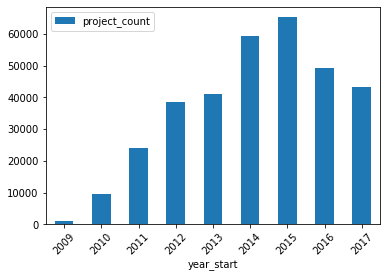

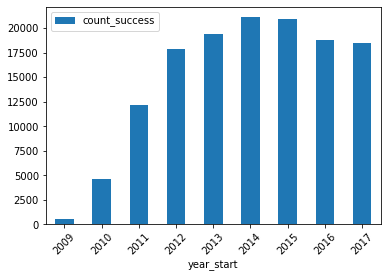

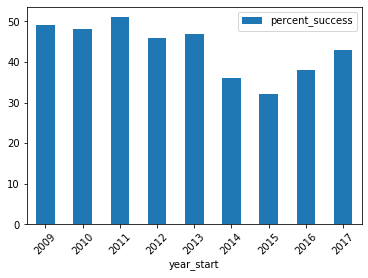

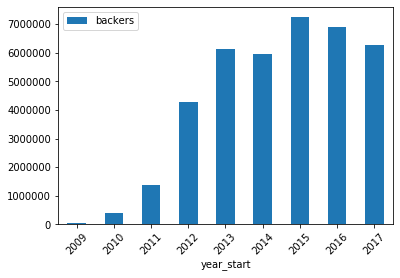

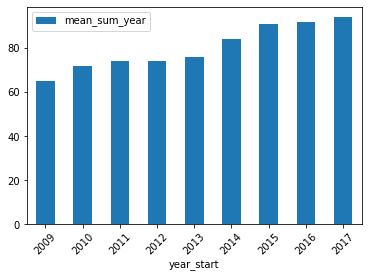

In [32]:
backer_year.project_count.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.count_success.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.percent_success.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.backers.plot(kind='bar', rot='45', legend=True)
plt.show()
backer_year.mean_sum_year.plot(kind='bar', rot='45', legend=True)
plt.show()

Можно отметить:
    - количество проектов устойчиво росло до 2015 года затем пошел небольшой спад
    - количество успешных проектов движется в том же направлении но с 2012 года изменения не так ярко выражены
    - в процентном соотношении обратная динамика до 2015 года затем направляется в рост, это можно связать с тем что количество человек делающих взносы меняется не с такой скоростью с какой увеличивается количество проектов. Что логично количество инвесторов и успехов примерно на одном уровне а проектов становится больше. Стоит задуматься о привличении людей делающих взносы.
    - средний взнос имеет небольшую положительную динамику
2014 и 2015 годы можно назвать пиком активности для проекта

Посмотри распределение успешности по общим категориям, месяцам, и странам(отделим США и Британию для наглядности на графике так как в этих странах количество значительно больше)

In [33]:
ks_pivot_main_category = ks.pivot_table(index = 'main_category', columns = 'state', values='result', aggfunc = 'count')
ks_pivot_month = ks.pivot_table(index = 'month_start', columns = 'state', values='result', aggfunc = 'count')
ks_pivot_country_no_usgb = ks[
    (ks['country'] != 'US') & (ks['country'] != 'GB')
].pivot_table(index = 'country', columns = 'state', values='result', aggfunc = 'count')
ks_pivot_country_usgb = ks[
    (ks['country'] == 'US') | (ks['country'] == 'GB')
].pivot_table(index = 'country', columns = 'state', values='result', aggfunc = 'count')

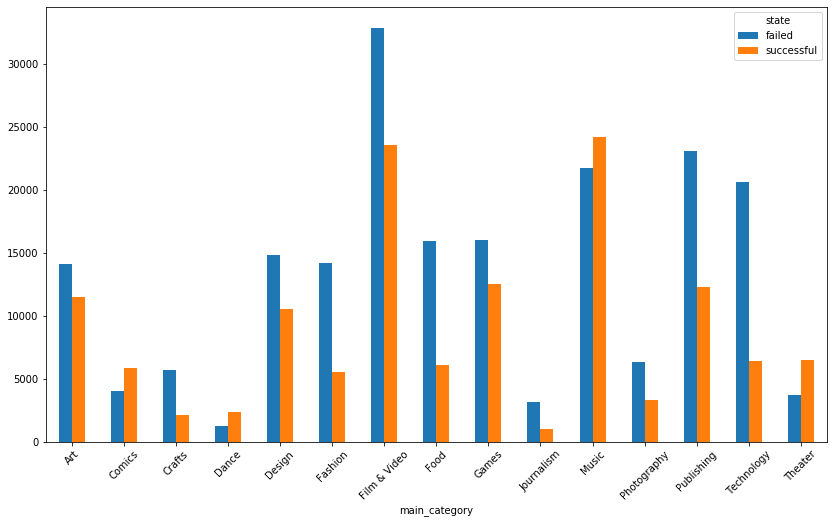

In [34]:
ks_pivot_main_category.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

- Можно отметить что успешных проектов было больше в категориях: Comics, Dance, Music, Theatre
    Можно сказать что в этих категориях шансы на успех выше чем в других 
- Более чем в два раз отстает количество успешных проектов в категориях: Crafts, Fashion, Food, Journalism, Technology
    В этих категориях шансы наоборот меньше
    
В целом заметно что предпочтение люди отдают проектам от искусства и развлечений и наоборот с производственными(товары, услуги) категориями.

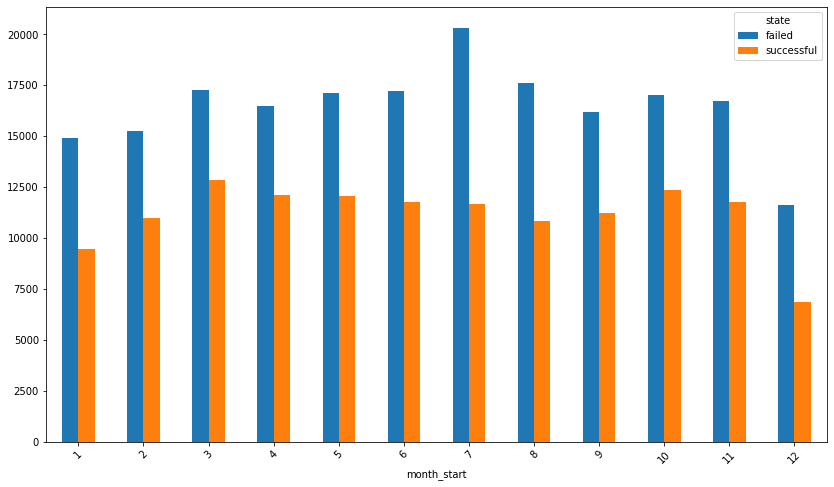

In [35]:
ks_pivot_month.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

Немного чаще успешными становятся проекты начала весны и середины осени в целом разница не значительная. Похуже обстоят дела в декабре.

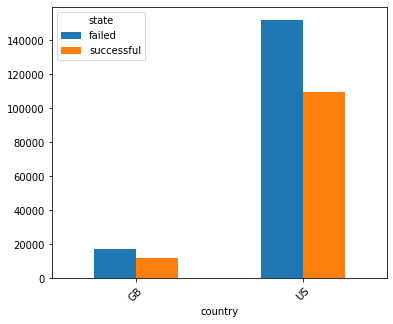

In [36]:
ks_pivot_country_usgb.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.show()

Наибольшей популярностью проект пользуется в США и Великобритании. В этих странах намного больше проектов в целом и высокие шансы на их успех.

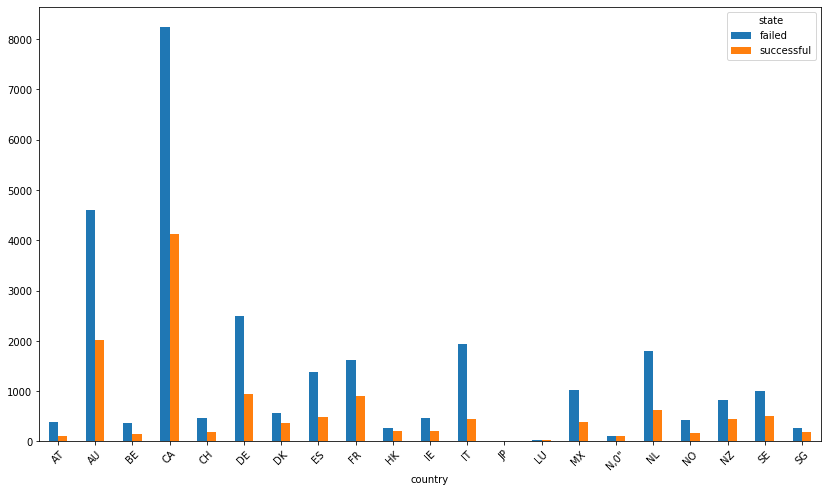

In [37]:
ks_pivot_country_no_usgb.plot(kind='bar', rot=45)
fig=plt.gcf()
fig.set_size_inches(14,8)
plt.show()

Немного меньше шансов у проектов из Италии и Австрии. Но в целом фактор страны не выглядит решающим для стран с маленьким количеством проектов.

Сделаем топ 10 категорий и стран по успешным проектам

In [38]:
ks_pivot_category = ks.pivot_table(index = 'category', columns = 'state', values='result', aggfunc = 'count')
ks_pivot_country = ks.pivot_table(index = 'country', columns = 'state', values='result', aggfunc = 'count')

In [39]:
ks_pivot_category.sort_values('successful', ascending=False).head(10)

state,failed,successful
category,,
Product Design,10718,7962
Tabletop Games,3878,7866
Shorts,4721,6673
Music,6201,6432
Documentary,8599,5924
Theater,2279,4405
Indie Rock,1711,3618
Rock,2746,3500
Art,4101,3385


В целом по узким категориям что логично сохраняется та же динамика что и в общих.

In [40]:
ks_pivot_country.sort_values('successful', ascending=False).head(10)

state,failed,successful
country,,
US,152061,109299
GB,17387,12067
CA,8236,4134
AU,4606,2010
DE,2499,937
FR,1612,908
NL,1794,617
SE,1000,509
ES,1381,492


Наибольшим количеством успешных проектов могут похвастать США, Великобритания что мы уже отмечали ранее. К ним можно добавить Канаду и Австралию.

Можно сделать вывод что у англоязычных стран дела на Kickstarter в целом обстоят лучше.

Топ 10 категорий в которых ищут поддержку

In [41]:
ks_pivot_main_category['count'] = ks_pivot_main_category['failed'] + ks_pivot_main_category['successful']
ks_pivot_main_category.sort_values('count', ascending=False).head(10)

state,failed,successful,count
main_category,,,
Film & Video,32904,23623,56527
Music,21752,24197,45949
Publishing,23145,12300,35445
Games,16003,12518,28521
Technology,20616,6434,27050
Art,14131,11510,25641
Design,14814,10550,25364
Food,15969,6085,22054
Fashion,14182,5593,19775


In [42]:
ks_pivot_category['count'] = ks_pivot_category['failed'] + ks_pivot_category['successful']
ks_pivot_category.sort_values('count', ascending=False).head(10)

state,failed,successful,count
category,,,
Product Design,10718,7962,18680
Documentary,8599,5924,14523
Music,6201,6432,12633
Tabletop Games,3878,7866,11744
Shorts,4721,6673,11394
Food,7119,3297,10416
Video Games,6942,2386,9328
Film & Video,5554,3070,8624
Fiction,5875,2233,8108


Можно сделать вывод, что чаще всего поддержку ищут проекты развлекательного типа и новых технологий.

Посмотрим сколько в среднем успешные проекты получали сверх цели, и сколько в среднем не хватало не успешным. Возьмем медиану так как существует ряд проектов с очень высокими или низкими показателями. Медианный показатель будет ближе для оценки среднестатистического проекта.

In [43]:
round(ks[ks['result']==1].usd_goal_real.median())

3838

In [44]:
round(ks[ks['result']==1].diff_money.median())

546

In [45]:
round(ks[ks['result']==0].usd_goal_real.median())

7500

In [46]:
round(ks[ks['result']==0].diff_money.median())

-6436

- Можно отметить что в среднем успешные проекты наберают незначительно больше средств.
- А не успешные в свою очередь не добирают большей части (примерно 90%)

Можно предположить что проекты обреченные на провал очевидны для большинства.

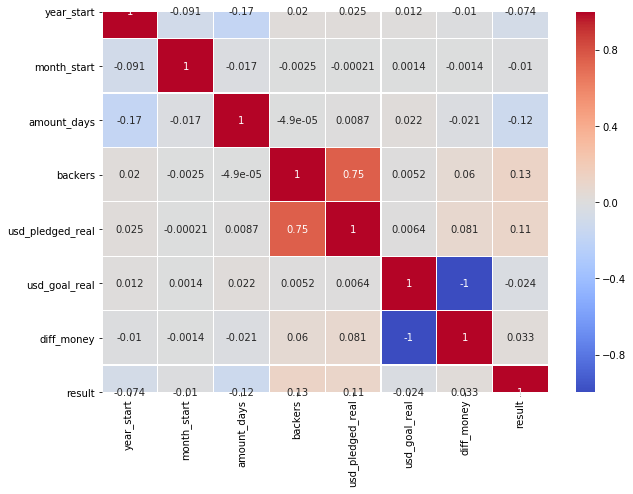

In [47]:
sns.heatmap(ks.corr(), annot=True, linewidths=0.3, cmap='coolwarm')
fig=plt.gcf()
fig.set_size_inches(10,7)

Значимых для исследования неочевидных взвимосвязей выявить не удалось

## Выдвинем гипотезу, что проекты из США и Великобритании, в категории Музыка, стартовавшие в марте или октябре более успешны чем остальные. 

In [48]:
target_sample = ks[
    (ks['country'] == 'US') | (ks['country'] == 'GB') & 
    (ks['main_category'] == 'Music') & 
    (ks['month_start'] == 3) | (ks['month_start'] == 10)
].result
other_sample = ks[
    (ks['country'] != 'US') & (ks['country'] != 'GB') & 
    (ks['main_category'] != 'Music') & 
    (ks['month_start'] != 3) & (ks['month_start'] != 10)
].result

In [49]:
statistics.variance(target_sample), statistics.variance(other_sample)

(0.24309931689186612, 0.20861946089558167)

In [50]:
stats.ttest_ind(target_sample, other_sample)

Ttest_indResult(statistic=40.767848630039076, pvalue=0.0)

In [51]:
descriptives, results = rp.ttest(target_sample, other_sample)

In [52]:
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,result,268255.0,0.416924,0.493051,0.000952,0.415058,0.418790
1,result,30621.0,0.296561,0.456749,0.002610,0.291445,0.301677
2,combined,298876.0,0.404593,0.490814,0.000898,0.402833,0.406352


Тест на дисперсию показал что выборки не имеют значительные отклонения по дисперсии.

pvalue < 0.05 значит выборки статистически различны, так же на это указывает различие средних показателей отвергаем нулевую гипотезу.

Выборки статистически различны. В целевой группе средний показатель выше, наша гипотеза верна.

## Построение предективной модели определения успешности проекта. Определение факторов наиболее влияющих на результат

Изменим текстовые данные на числовые

In [53]:
label = LabelEncoder()
dicts = {}

label.fit(ks.category)
dicts['category'] = list(label.classes_)
ks.category = label.transform(ks.category)

label.fit(ks.main_category)
dicts['main_category'] = list(label.classes_)
ks.main_category = label.transform(ks.main_category)

label.fit(ks.country)
dicts['country'] = list(label.classes_)
ks.country = label.transform(ks.country)

In [54]:
input_x = ks[['category', 'main_category', 'country', 'month_start',
              'amount_days', 'usd_goal_real']]
Y = ks['result']

In [55]:
x_train, x_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.3)

Построим модель Random Forest

In [56]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Определим наиболее важные атрибуты для успешности проекта

No handles with labels found to put in legend.


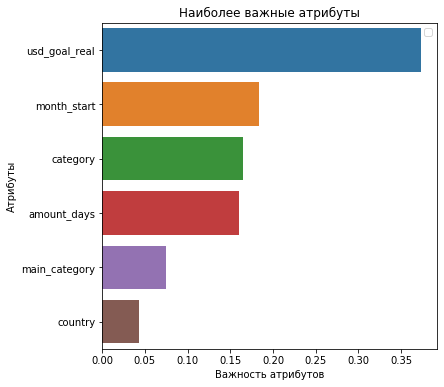

In [57]:
headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title('Наиболее важные атрибуты')
plt.legend()
plt.show()

Самым значительным оказался фактор требуемой суммы 

Оценим точность модели

In [58]:
model_pred = model.predict(x_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72     59268
           1       0.57      0.51      0.54     40235

    accuracy                           0.65     99503
   macro avg       0.63      0.63      0.63     99503
weighted avg       0.64      0.65      0.64     99503



In [59]:
model.score(x_test, y_test)

0.648844758449494

Другой вариант модели:

In [60]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

In [61]:
clf.score(x_test, y_test)

0.614363386028562